# Capstone Project - The Battle of Neighborhoods

## Introduction

This final project aims to explore Japanese restaurants located in the city of New York. New York city is home to thousands of different restaurants which are spread across its five boroughs. Japanese cuisine has seen a significant increase in popularity in the last few decades and this has in turn resulted in numerous Japanese restaurants populating New York city. This report will compare Japanese restaurants in New York city in order to establish the best places to find Japanese cuisine in the city. Also, the report will provide insights into the frequency and average rating of Japanese restaurants around New York city which can be used to determine where a new Japanese restaurant may have the greatest success.

## Data

In order to carry out the analysis, data on New York City neighbourhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighbourhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of Japanese restaurants will be obtained via the Foursquare API utilized via the Request library in Python.

## Methodology

The first step in carrying out this analysis involves obtaining the relevant data. This is done by retrieving the data from https://cocl.us/new_york_dataset. The data is then cleaned and processed into a dataframe.

Using Foursquare, Japanese restaurants and their accompanying information is collected by locating all venues and filtering the search for Japanese restaurants. The number of restaurants located in each borough is determined along with the neighbourhoods they are found in. The information will include number of likes, ratings and tips for each of the Japanese restaurants retrieved.

Following the collecting and processing of the data, restaurants with the greatest likes, ratings and tips are determined and average ratings of Japanese restaurants in each neighbourhood are generated using the dataframe.
Finally, a map visualising the data is generated which pinpoints the location of each of the Japanese restaurants that are used in this analysis.

## Importing required libraries...

In [3]:
import pandas as pd
import numpy as np
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage

import seaborn as sns

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
! pip install geocoder
import geocoder

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


## Defining Foursquare credentials and version...

In [4]:
CLIENT_ID = 'PGEXGZARW1WL1CKCC4VYCGZAY1YLQQJDAJUIE4WKBKGTORJ2' # your Foursquare ID
CLIENT_SECRET = '2AYCRKOJUVHCE3FOVI2OBU21HTOXSKFHMSQHW3DHWN2ADA10' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [6]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
ny_data.shape

(306, 4)

According to the data used, there are 306 neighbourhoods in New York city.

## Plotting the number of neighbourhoods per borough as a bar chart...

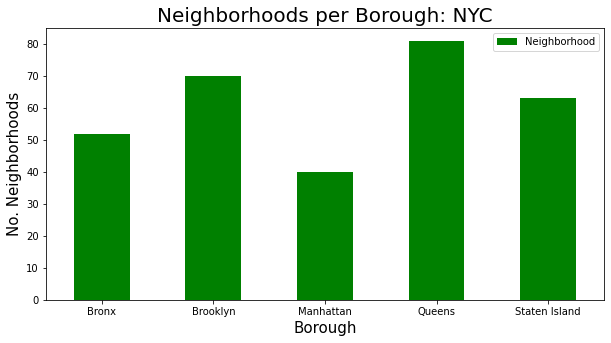

In [8]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

According to the data, Queens has most neighborhoods out of all boroughs in the city.
## Preparing neighborhood list that contains japanese restaurants...

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [11]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [12]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
66,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
67,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
68,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
69,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou
70,Brooklyn,Dumbo,5cf1562460255e002c5e683c,Bessou


In [13]:
japanese_rest_ny.shape

(71, 4)

71 Japanese Restaurants across the New York City have been identified.

## Plotting Japanese restaurants per borough and per neighbourhood as bar charts...

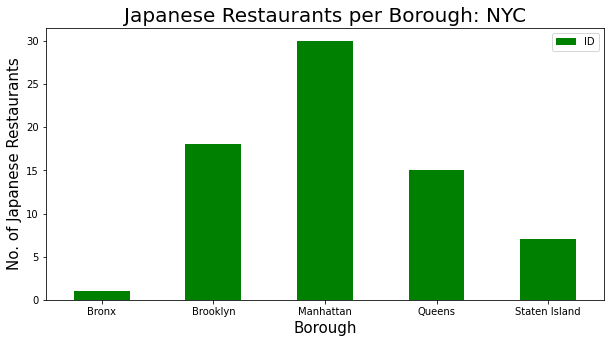

In [14]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

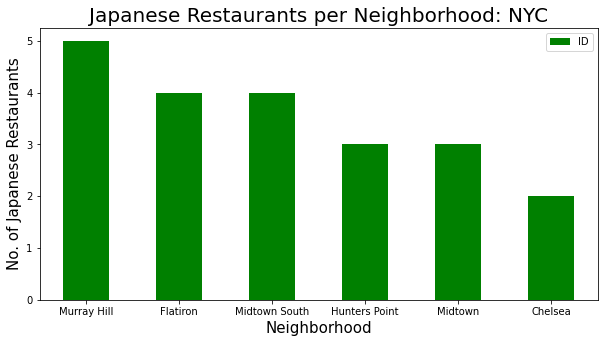

In [15]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [16]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
21,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
22,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
23,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
24,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
41,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


Though Manhattan had the least number of neighborhoods, we can see from the analysis that it has the highest number of Japanese restaurants. The Bronx only appears to have two Japanese restaurants. In addition, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Murray Hill has the highest number of Japanese restaurants and is actually located in the boroughs of Manhattan and Queens.

Now that we have determined the locations in which Japanese restaurants are most densly populated, we can begin to extend our analysis by taking the ratings of the restaurants into consideration.

## Ranking the restaurants based on a number factors...

In [17]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()


{'meta': {'code': 200, 'requestId': '5f4f8f81474df2295653c24b'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
66,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish,454,8.8,102
67,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago,157,8.4,26
68,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant,11,7.4,5
69,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou,11,8.2,1
70,Brooklyn,Dumbo,5cf1562460255e002c5e683c,Bessou,11,8.2,1


In [18]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [19]:
japanese_rest_stats_ny.shape

(71, 7)

In [20]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       71 non-null     object 
 1   Neighborhood  71 non-null     object 
 2   ID            71 non-null     object 
 3   Name          71 non-null     object 
 4   Likes         71 non-null     object 
 5   Rating        71 non-null     float64
 6   Tips          71 non-null     object 
dtypes: float64(1), object(6)
memory usage: 4.0+ KB


In [21]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Rating'] = japanese_rest_stats_ny['Rating'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       71 non-null     object 
 1   Neighborhood  71 non-null     object 
 2   ID            71 non-null     object 
 3   Name          71 non-null     object 
 4   Likes         71 non-null     float64
 5   Rating        71 non-null     float64
 6   Tips          71 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.0+ KB


In [22]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,71.000000,71.000000,71.000000
mean,153.295775,7.616901,45.338028
std,251.466578,2.044993,71.018497
min,0.000000,0.000000,0.000000
25%,11.000000,7.450000,5.000000
50%,47.000000,8.200000,14.000000
75%,188.500000,8.700000,54.000000
max,1221.000000,9.200000,353.000000


## Determining the restaurants with the greatest number of likes, rating and tips...

In [23]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              4f7b61f6e4b07aaa5d524842
Name                 OOTOYA 大戸屋 (OOTOYA)
Likes                               1221
Rating                               8.9
Tips                                 274
Name: 65, dtype: object

In [24]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              510c85e7e4b0056826b88297
Name                                Kura
Likes                                213
Rating                               9.2
Tips                                  62
Name: 27, dtype: object

In [25]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                792
Rating                               8.7
Tips                                 353
Name: 26, dtype: object

## Determining the neighbourhoods with the highest average ratings...

### NOTE: The Bronx was omitted as only one Japanese restaurant was retrieved...

In [27]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood', 'Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
12,East Village,9.200000
8,Cobble Hill,9.100000
24,Hunters Point,9.033333
37,Park Slope,9.000000
42,Soho,8.900000
36,North Side,8.900000
1,Boerum Hill,8.900000
15,Flatiron,8.825000
16,Fort Greene,8.800000
28,Lindenwood,8.800000


In [28]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

new_ny_borough_stats = ny_borough_stats.drop(index=0)

new_ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.400000
1,Brooklyn,8.188889
3,Queens,6.680000
4,Staten Island,5.885714


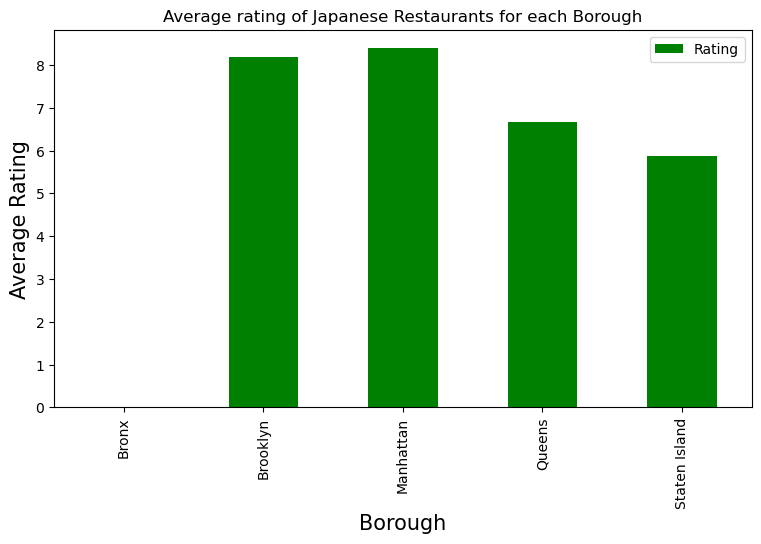

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [30]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.000000
1,Boerum Hill,8.900000
2,Brooklyn Heights,8.100000
6,Chelsea,8.700000
8,Cobble Hill,9.100000
10,Downtown,8.600000
11,Dumbo,8.200000
12,East Village,9.200000
14,Financial District,8.050000
15,Flatiron,8.825000


In [31]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.000000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.900000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.100000
3,Manhattan,Chelsea,40.744035,-74.003116,8.700000
4,Staten Island,Chelsea,40.594726,-74.189560,8.700000
5,Brooklyn,Cobble Hill,40.687920,-73.998561,9.100000
6,Brooklyn,Downtown,40.690844,-73.983463,8.600000
7,Brooklyn,Dumbo,40.703176,-73.988753,8.200000
8,Manhattan,East Village,40.727847,-73.982226,9.200000
9,Manhattan,Financial District,40.707107,-74.010665,8.050000


In [32]:
address = 'New York City, NY'

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##########################

## Creating a map which pinpoint locations of each Japanese restaurant...

In [33]:
ny_map = folium.Map(location=[latitude, longitude], zoom_start=11)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [34]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Results

Based on the data used in this analysis, Manhattan has the greatest number of Japanese restaurants in New York city by a considerable margin. The Bronx has the lowest number of Japanese restaurants. Murray Hill, Manhattan is the neighbourhood with the greatest number of Japanese restaurants in New York.

OOTOYA in the neighbourhood of Flatiron, Manhattan boasts the greatest number of likes with 1221. Kura in the neighbourhood of East Village, also in Manhattan, has the greatest rating of 9.2. The greatest number of tips for a Japanese restaurant was found to be 353 and was attributed to Morimoto in the neighbourhood of Chelsea, Manhattan.

Manhattan has the highest average rating for Japanese restaurants, followed closely by Brooklyn and Queens. The neighbourhood with the greatest average rating for Japanese restaurants was East Village, Manhattan followed by Cobble Hill, Brooklyn and Hunters Point, Queens.

## Discussion

It is clear to see that the best place to find high quality Japanese cuisine in New York city is Manhattan. Not only does Manhattan have the greatest number of Japanese restaurants, it also has the highest average rating of all five boroughs. In addition, it is home to the Japanese restaurants with the greatest number of likes, highest rating and greatest number of tips.

The analysis provides many insights for the prospective Japanese restaurant owner. The market for Japanese cuisine is clearly greatest in the boroughs of Manhattan, Brooklyn and Queens and the average ratings for these boroughs are high. Due to the large number of Japanese restaurants already established in Manhattan, it would be advisable to open a new restaurant in Brooklyn or Queens due to the reduced competition. Also, real estate prices are an important consideration. Given the high average ratings of Brooklyn Japanese restaurants, relatively cheap real estate prices and comparatively less competition, opening a restuarant in Brooklyn may be the best option.

## Conclusion

From carrying out this analysis of Japanese restaurants in New York city, it can be concluded that Manhattan is the best place for a customer to find high quality Japanese cuisine with the greatest selection of restaurants and also the greatest average rating. High quality Japanese cuisine can be found in other boroughs such as Brooklyn and Queens which both have high averge ratings but are less frequently located in these boroughs.

For the potential business owner, to avoid competion and high real estate prices but to also retain a high rating, Brooklyn may be the best place to open a new Japanese restaurant.